# Pulmonary Fibrosis Starter Notebook

In [53]:
import numpy as np
import pandas as pd

import time

import albumentations as albu
from albumentations.pytorch import ToTensor
import PIL
import cv2 as cv

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding, get_model_params

from tqdm import tqdm_notebook, tqdm

import pydicom
from glob import glob

from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# check the device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Prepare the Data

To train the model I will fit linear regression models to patient's data and then use deep learning to predict the linear model coefficients.

In [3]:
DATA_DIR = './pulmonary_fibrosis_data/'
TRAIN_DIR = './pulmonary_fibrosis_data/train/'
TEST_DIR = './pulmonary_fibrosis_data/test/'

train_df = pd.read_csv(DATA_DIR + 'train.csv')
test_df = pd.read_csv(DATA_DIR + 'test.csv')

In [4]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
patients = train_df.Patient.unique()

In [6]:
patients[:4]

array(['ID00007637202177411956430', 'ID00009637202177434476278',
       'ID00010637202177584971671', 'ID00011637202177653955184'],
      dtype=object)

In [31]:
quantiles = np.array([.6, .4])

def fit_model(model, quantile):
    """Fitting quantile regression model.
    
    Details:
    https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html
    """
    res = model.fit(q=quantile)
    return [quantile, res.params['Intercept'], res.params['Weeks']] + \
            res.conf_int().loc['Weeks'].tolist()

def fit_regression_models(patient_data, quantiles=np.array([.6, .4])):
    """Fit quantile regression models and OLS model."""
    patient_data = patient_data.sort_values(by=['Weeks'], ascending=True)
    x = patient_data['Weeks'].values.reshape(-1,1)
    y = patient_data['FVC'].values.flatten()
    
    model = smf.quantreg('FVC ~ Weeks', patient_data)
    models = [fit_model(model, x) for x in quantiles]
    models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])
    
    ols = smf.ols('FVC ~ Weeks', patient_data).fit()
    ols_ci = ols.conf_int().loc['Weeks'].tolist()
    ols = dict(a = ols.params['Intercept'],
               b = ols.params['Weeks'],
               lb = ols_ci[0],
               ub = ols_ci[1])
    
    models = models.append(ols, ignore_index=True)
    
    return models

In [32]:
patient = patients[np.random.randint(len(patients))]
models = fit_regression_models(train_df[train_df.Patient == patient])

In [33]:
models

,q,a,b,lb,ub
0,0.6,1919.666672,-1.185185,NaN,NaN
1,0.4,1854.124995,-0.875000,NaN,NaN
2,NaN,1937.579078,-1.408634,-7.473283,4.656015


In [34]:
def lin_func(x, a, b):
    """Linear function."""
    return a + b * x

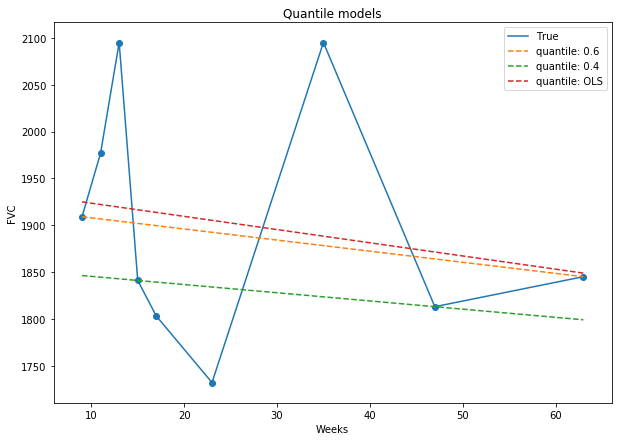

In [35]:
# gets patient's data
patient_data = train_df[train_df.Patient == patient]
patient_data = patient_data.sort_values(by=['Weeks'], ascending=True)
x = patient_data['Weeks'].values.reshape(-1,1)
y = patient_data['FVC'].values.flatten()
    
# plots FVC vs weeks
plt.figure(figsize=(10,7))
plt.title('Quantile models')
plt.plot(x, y, label='True')
plt.scatter(x, y)

# plots quantile and OLS regression results
xs = np.linspace(np.min(x), np.max(x), 20)
for i, row in models.iterrows():
    q = row.q
    a = row.a
    b = row.b
    label = str(q) if str(q)!='nan' else 'OLS'
    plt.plot(x, lin_func(x,a,b), label = 'quantile: ' + label,
            linestyle='--')


plt.xlabel('Weeks')
plt.ylabel('FVC')

plt.legend()
plt.show()

In [42]:
def add_regression_coefficients(train_df, quantiles):
    models_data = pd.DataFrame()
    for patient in patients:
        # Fit the resgrission models
        models = fit_regression_models(train_df[train_df.Patient == patient])
        models['q'] = models['q'].fillna(0.5)
        lower = models[models.q == quantiles[0]]
        upper = models[models.q == quantiles[1]]
        ols = models[models.q == 0.5]
        models_data = models_data.append(
        {
            'Patient': patient,
            'a_lower': lower.a.values[0],
            'a_ols': ols.a.values[0],
            'a_upper': upper.a.values[0],
            'b_lower': lower.b.values[0],
            'b_ols': ols.b.values[0],
            'b_upper': upper.b.values[0],
        }, ignore_index=True)
        
    models_data = models_data.merge(train_df, on=['Patient'])
    return models_data

In [45]:
train_data = add_regression_coefficients(train_df, quantiles)

d:\pycharmprojects\lexie\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
d:\pycharmprojects\lexie\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
d:\pycharmprojects\lexie\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
d:\pycharmprojects\lexie\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
d:\pycharmprojects\lexie\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarn

In [46]:
train_data.head()

,Patient,a_lower,a_ols,a_upper,b_lower,b_ols,b_upper,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,11,2069,52.063412,79,Male,Ex-smoker


## Prepare the Datasets for Deep Learning

### Prepare the Data Transforms

In [50]:
# setup image hight and width
HEIGHT = 256
WIDTH = 256
SIZE = 128

# setup the transformations pipelines
def train_transforms(p=.5):
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        albu.HorizontalFlip(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=p),
        albu.Blur(blur_limit=3),
        albu.OpticalDistortion(),
        albu.GridDistortion(),
        albu.Resize(height = SIZE, width = SIZE)
    ], p=1.0)

def valid_transforms():
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        albu.Resize(height = SIZE, width = SIZE)
    ], p=1.0)

In [69]:
train_fns = glob(TRAIN_DIR+'/*/*.dcm')

def visualize_augmentations(n_rows=3, n_cols=3):
    transform = train_transforms(p=.8)
    
    idx = np.random.randint(0, len(train_fns))
    fname = train_fns[idx]
    image = pydicom.read_file(fname).pixel_array
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    for i in range(n_rows):
        for j in range(n_cols):
            
            augmented_image = transform(image=image)['image']

            axs[i,j].imshow(augmented_image, cmap='bone')
            axs[i,j].axis('off')

    plt.suptitle('Examples of augmentations {}'.format(fname.split('/')[-2]))
    plt.show()

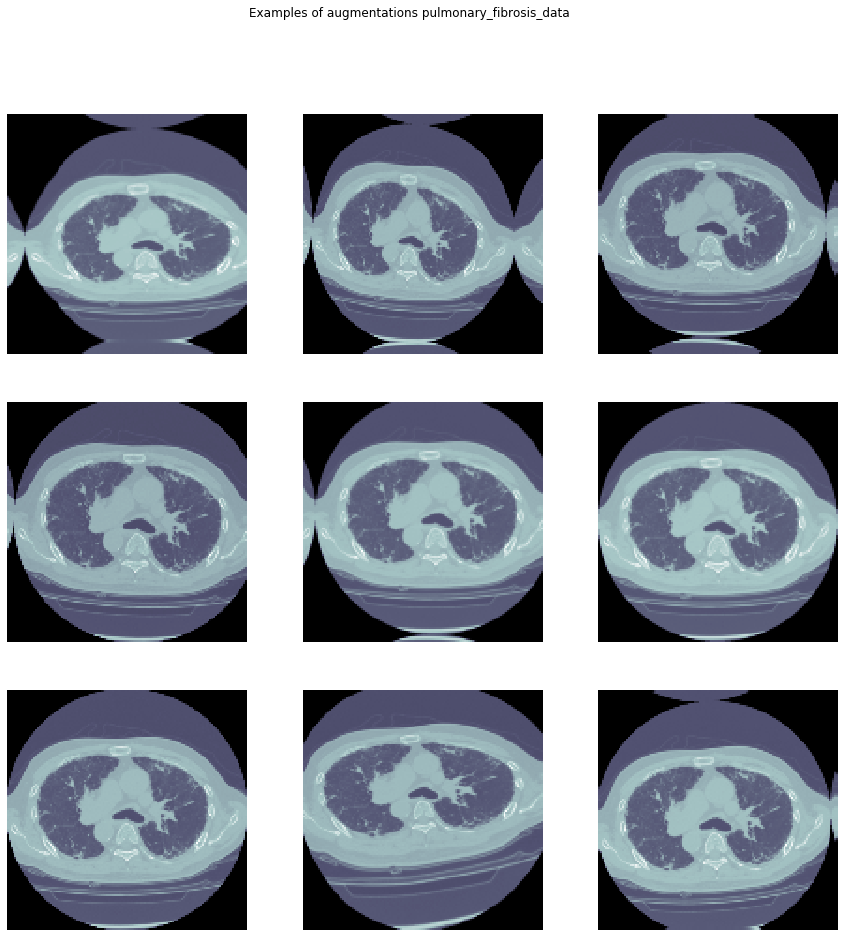

In [70]:
visualize_augmentations()

### Prepare the Dataset

In [122]:
class PulmonaryFibrosisDataset(Dataset):
    '''
    Create custom Pulmonary Fibrosis dataset
    '''
    def __init__(self, data, data_dir, transforms, validation = False):
        self.data = data
        self.data_dir = data_dir
        self.transforms = transforms
        self.validation = validation
        
        self.fns = glob(data_dir + '/*/*.dcm')
        self.n_images = len(self.fns)

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        filename = self.fns[idx]
        if not self.validation:
            image = pydicom.read_file(filename).pixel_array
            aug = self.transforms(image=image)
            
            patient = filename.split('\\')[-2]
            
            data = self.data[(self.data.Patient == patient)]
            arr = np.array([data['a_lower'].values[0], 
                   data['a_ols'].values[0],
                   data['a_upper'].values[0],
                   data['b_lower'].values[0],
                   data['b_ols'].values[0],
                   data['b_upper'].values[0]])
                   
            return torch.tensor(aug['image'].astype(int)),  torch.tensor(arr)
        else:
            image = pydicom.read_file(filename).pixel_array
            aug = self.transforms(image=image)
            
            patient = filename.split('\\')[-2]
            
            return torch.tensor(aug['image'].astype(int)), patient

Check samples from the dataset:

In [123]:
train_dataset = PulmonaryFibrosisDataset(train_data, TRAIN_DIR, train_transforms())
sample_trainloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)

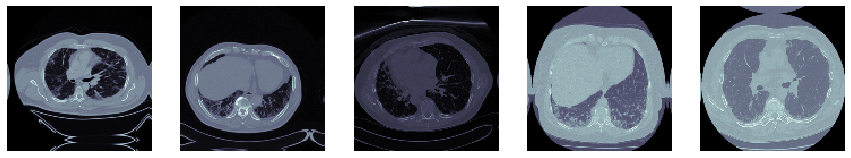

In [125]:
# plot sample train data
for img, labels in sample_trainloader:
    
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(img[i].reshape(SIZE, SIZE), cmap='bone')
        axs[i].axis('off')
        
    break;

## Define the Model